In [1]:
%env MKL_NUM_THREADS=20
%env OMP_NUM_THREADS=20

env: MKL_NUM_THREADS=20
env: OMP_NUM_THREADS=20


In [2]:
import numpy as np
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import (find_optimal_svd_rank,
                                         find_optimal_config,
                                         set_config)

from scaledsvd import ScaledSVD, ScaledSVDItemColdStart
from data_preprocessing import (get_amazon_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)
%matplotlib inline

In [3]:
from polara.recommender import defaults
defaults.memory_hard_limit = 15 # allowed memory usage during recommendations generation

In [4]:
seed = 42

In [5]:
experiment_name = 'scaledsvd'

# Experiment setup

In [6]:
data_labels = ['AMZe', 'AMZvg']

In [7]:
ranks_grid = [1, 5, 10, 15, 20, 30, 50, 60, 75, 100, 125, 150, 200, 250, 300,
              350, 400, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
svd_ranks = {'AMZe': ranks_grid,
             'AMZvg': ranks_grid
            }

In [8]:
scaling_params = [0.2, 0.4, 0.6]

In [9]:
topk_values = [1, 3, 10, 20, 30]

In [10]:
target_metric = 'mrr'

In [11]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [12]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Amazon Electronics

In [13]:
lbl = 'AMZe'

In [14]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('/mnt/bulky/datasets/recsys/amazon/ratings_Electronics.csv',
                                                 meta_path='/mnt/bulky/datasets/recsys/amazon/meta/meta_Electronics.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [15]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [16]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Amazon Video Games

In [17]:
lbl = 'AMZvg'

In [18]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('/mnt/bulky/datasets/recsys/amazon/ratings_Video_Games.csv',
                                                 meta_path='/mnt/bulky/datasets/recsys/amazon/meta/meta_Video_Games.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_data={'categories': ['Games']}, # filter uniformative category
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [19]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [20]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [21]:
print_data_stats(data_labels, all_data)

AMZe
{'userid': 124895, 'asin': 44843}
density 0.019153791836615672
similarity matrix density 1.1054998336712965
AMZvg
{'userid': 14251, 'asin': 6858}
density 0.13281340440589384
similarity matrix density 9.081814734274188


# Standard experiment

In [22]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [ScaledSVD(data_model)]
    apply_config(models, config, data_label)
    return models

def fine_tune_scaledsvd(model, ranks, scale_params, label, record_time=False):
    param_grid = [(s, r) for s in scale_params for r in reversed(list(sorted(ranks)))]
    param_names = ('col_scaling', 'rank')
    best_svd_config, svd_scores = find_optimal_config(model, param_grid, param_names,
                                                      target_metric,
                                                      return_scores=True,
                                                      force_build=False,
                                                      iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_svd_config))}
    model_scores = {model.method: svd_scores}
    try:
        if record_time:
            max_rank = max(ranks)
            save_training_time(f'{experiment_name}_rank_{max_rank}', model, svd_scores.xs(max_rank, level='rank').index, label)
    finally:
        return model_config, model_scores

## tuning

In [23]:
config = {}
scores = {}
data_models = {}

In [24]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    config[label], scores[label] = fine_tune_scaledsvd(ScaledSVD(data_models[label]),
                                                       svd_ranks[label],
                                                       scaling_params,
                                                       label, record_time=True)

 [████████████████████████████████████████████████████████████] 2/2 [02:43:24<12:03, 4902.09s/it]

           AMZe [█████████████████████████████████████████████] 78/78 [02:31:12<00:07, 116.30s/it]

          AMZvg [█████████████████████████████████████████████] 78/78 [12:02<00:01, 9.26s/it]

/home/evfro/miniconda3/envs/polara_dev/lib/python3.6/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


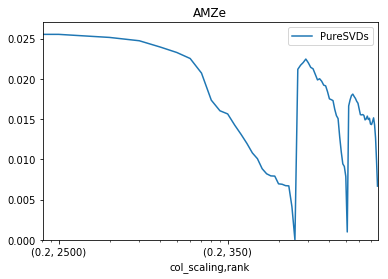

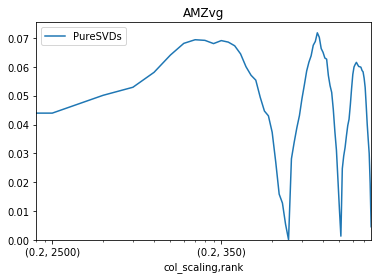

In [25]:
report_results('rank', scores);

In [26]:
config

{'AMZe': {'PureSVDs': {'col_scaling': 0.2, 'rank': 3000}},
 'AMZvg': {'PureSVDs': {'col_scaling': 0.4, 'rank': 300}}}

### saving data

In [27]:
save_results(experiment_name, config=config, tuning=scores)

## cross-validation

In [28]:
result = {}

for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, config)
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=f'{label} folds'))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 2/2 [03:59:04<00:22, 7172.01s/it]

     AMZe folds [█████████████████████████████████████████████] 5/5 [03:58:42<47:27, 2864.49s/it]

    AMZvg folds [█████████████████████████████████████████████] 5/5 [00:22<00:04, 4.30s/it]

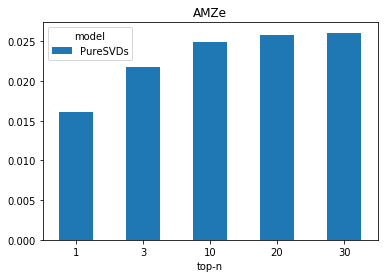

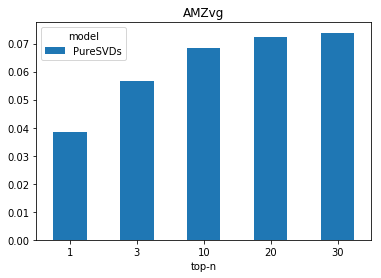

In [29]:
report_results('topn', result, target_metric);

### saving data

In [31]:
save_results(experiment_name, cv=result)

# Cold start

In [32]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [ScaledSVDItemColdStart(data_model, item_features=meta_dict[data_label])]
    apply_config(models, config, data_label)
    return models

## tuning

In [33]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [34]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model = ScaledSVDItemColdStart(data_models_cold[label],
                                   item_features=meta_dict[label])
    model.use_raw_features = True
    config_cold[label], scores_cold[label] = fine_tune_scaledsvd(model,
                                                                 svd_ranks[label],
                                                                 scaling_params,
                                                                 label, record_time=False)

 [████████████████████████████████████████████████████████████] 2/2 [02:46:14<12:38, 4987.05s/it]

           AMZe [█████████████████████████████████████████████] 78/78 [02:33:32<00:17, 118.10s/it]

          AMZvg [█████████████████████████████████████████████] 78/78 [12:38<00:00, 9.71s/it]

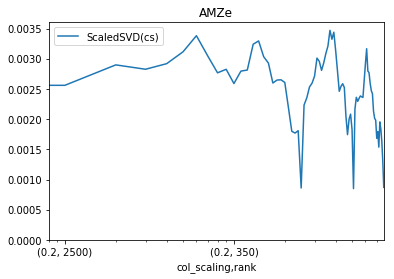

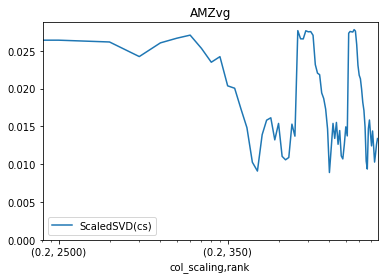

In [35]:
report_results('rank', scores_cold);

In [36]:
config_cold

{'AMZe': {'ScaledSVD(cs)': {'col_scaling': 0.4, 'rank': 300}},
 'AMZvg': {'ScaledSVD(cs)': {'col_scaling': 0.6, 'rank': 1500}}}

### saving data

In [39]:
save_results(experiment_name+'_coldstart', config=config_cold, tuning=scores_cold)

## cross validation

In [40]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold, config_cold)
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=f'{label} folds'))

 [████████████████████████████████████████████████████████████] 2/2 [12:01<06:52, 360.53s/it]

     AMZe folds [█████████████████████████████████████████████] 5/5 [05:09<01:01, 61.88s/it]

    AMZvg folds [█████████████████████████████████████████████] 5/5 [06:52<01:24, 82.33s/it]

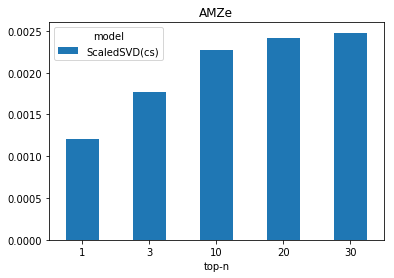

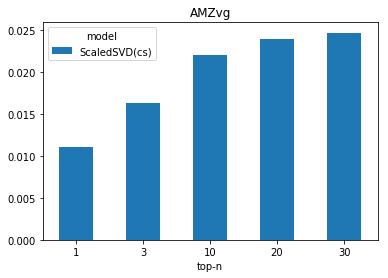

In [41]:
report_results('topn', result_cold, target_metric);

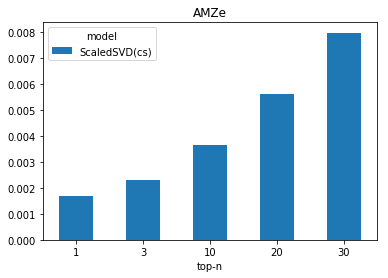

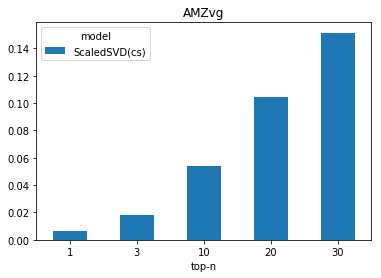

In [42]:
report_results('topn', result_cold, 'coverage');

### saving data

In [43]:
save_results(experiment_name+'_coldstart', cv=result_cold)